# Assignment 4: Generative Adversarial Network (GAN) for Pokemon Image Generation

## Abstract:

The goal of this assignment is to generate Pokemon type images from a GAN by training through a dataset of 819 images of real pokemons. The type of GAN implemented is DCGAN with two different approaches of loading the images. First part of the assignment uses DCGAN with greyscale images and the second part uses RGB-Red Blue Green colored images. It is observed that the quality of images generated with color pixels looks more appealing and with perfect amount of epochs a new pokemon can be visualised.

## Problem Statement

Generate content by training a Generative Adversarial Network(GAN) with a dataset of media and visualise a new appealing figure from GAN.

## Introduction to the data

The images dataset has 819 transparent Pokemon images in png format size 256x256. Images are retreived mostly from this website https://veekun.com/dex/downloads

Each pokemon has a unique body structure which makes the discriminator to easily distinguish the generated image. The images are converted to a size of (32,32) pixels and (28,28) depending on the convolution of the layers in the network.

## Solution approach

Firstly, the generative model is initialised with some random noise with same set of pixels are per input images and generator constantly interactors with the discriminator for feedback and learns by reducing the error which is defined with 'cross entropy' and tried to lessen the error. The procedure happens for a defined number of epochs and the results of generated images are observed for valid and appealing shapes and then the number of epochs is increased to the extent of visually good images. The process of convolution layers is different for greyscale images and colored RGB images. 

Finally, the results are evaluated for accuracy in unreal images as given by the discriminator. The more the accuracy of fake generated images, the better model performed.

### Importing the libraries required for this code.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam
import glob
import imageio
import PIL
from tensorflow.keras import layers
from IPython import display

### Sample images of Pokemon are shown below

Found 819 images belonging to 1 classes.


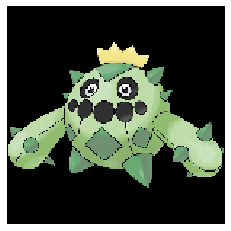

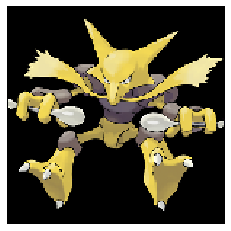

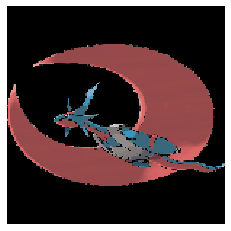

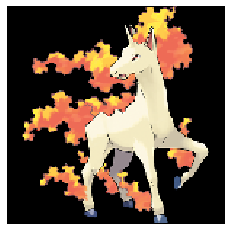

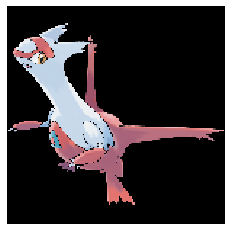

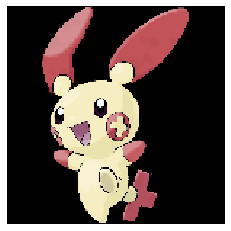

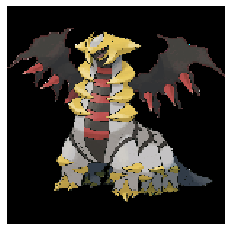

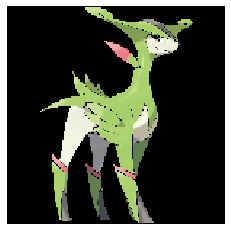

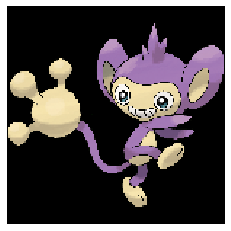

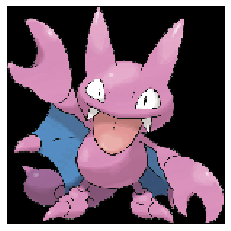

In [2]:
image_gen = ImageDataGenerator(rescale=1./255)
path = '/Users/mahi/Downloads/pokemon'
sample_data = image_gen.flow_from_directory(batch_size=128, directory=path, shuffle=True, target_size=(150,150))
image = sample_data.next()[0]
for i in range(10):
    plt.axis('off')
    plt.imshow(image[i])
    plt.show()

## Part 1: Deep Convolutional Generative Adversarial Network (DCGAN) using greyscale pokemon images

We use ImageDataGenerator() to load images and encode them to an array of numbers. The arguments to be needed are directory of the images, shuffle=True, target_size of the image (28,28)

In [3]:
image_gen = ImageDataGenerator(rescale=1./255)
path = '/Users/mahi/Downloads/pokemon'

In [4]:
train_images_data = image_gen.flow_from_directory(batch_size=128, directory=path,
                             shuffle=True, target_size=(28,28))

Found 819 images belonging to 1 classes.


The 'train_images_data' has the nested array of encoded images with their labels. Here we dont define any label to the image so the default value of 0 is applied. The shape of the array is (128, 28, 28, 3) which means there are 128 images in a batch of size (28,28) (rows,columns) of three channels or dimensions.

In [5]:
train_images_data.next()[0].shape

(128, 28, 28, 3)

The images are not yet converted to greyscale and they are using the below code and the output variable 'greyscaled' will have one channel

In [6]:
grayscaled =[]
for i in train_images_data.next()[0]:
    grayscaled.append(tf.image.rgb_to_grayscale(i))
    
grayscaled

[<tf.Tensor: shape=(28, 28, 1), dtype=float32, numpy=
 array([[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],


In [7]:
train_images = np.array(grayscaled,dtype=float)

The images will now have one dimension of shape (128,28,28,1)

In [8]:
train_images.shape

(128, 28, 28, 1)

Defining the buffer size and batch size for obtaining a more shuffled dataset

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 512

train_dataset will have data of encoded greyscale images of batch_size 512 and buffer_size 60000

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Defining the generator for GAN

In [11]:
def make_generator_model():
    # starting with a sequential layer
    model = tf.keras.Sequential()
    
    #Defining the dense layers with bias and activation function to the neurons 
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Reshaping layer for transforming the noise added to the generator 
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # None is the batch size

    #Transforming the layers for training
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Finally making sure that the output of generator matches with the input of discriminator
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

##### Random noise added to the generator to start with

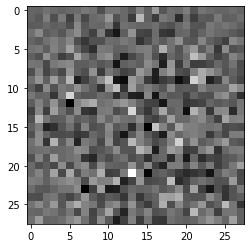

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Defining the discriminator

The discriminator is defined to interpret the images with few layers of convolution and therbey judging the output of generator

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

The output of discriminator is more or less a tensor that is used to estimate the loss of real and fake closeness of the generated image

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00076502]], shape=(1, 1), dtype=float32)


## Defining loss functions and optimizers for both models

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator Loss:

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator Loss:

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.



In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
A way to save and restore models, which can be helpful in case a long running training task is interrupted.

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Defining a Training Loop

In [20]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 30

# We will reuse this seed overtime
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [21]:
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [46]:
def train_1(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,epochs,seed)

### Generating and save images

In [25]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Calling the train() method defined above to train the generator and discriminator simultaneously. It's important that the generator and discriminator do not overpower each other

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 1000 epochs, they resemble little pokemon images.

In [ ]:
train_1(train_dataset, 400)

image_at_epoch_1000

## Generated Pokemon Images
  <center>
    <img src="image_at_epoch_1000.png" width=1000 height=1000 />
</center>
<center>
    Fig. Generated Pokemon Images
</center>

#### Restoring with the help of checkpoints

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(1000)

## Conclusion for Part 1:

Initially, the GAN model is trained with the help of discriminator and with the help of losses, the optimiser tries to minimise the loss using 'Adam' optimiser and loss estimimated using cross entropy is minimised after a significantly large number of epochs.

## Part 2: DCGAN with colored RGB images

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
#from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import ones
from numpy import zeros
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot

Defining imagedatagenerator() for loading images

The images are just converted to size of (32,32)

In [30]:
image_gen = ImageDataGenerator(rescale=1./255)
path = '/Users/mahi/Downloads/pokemon'

In [31]:
train_images_data = image_gen.flow_from_directory(batch_size=128, directory=path,
                             shuffle=True, target_size=(32,32), )

Found 819 images belonging to 1 classes.


In [32]:
train_images = train_images_data.next()[0]
train_images

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

## Defining discriminator

In [33]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
# normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
# downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
# downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
# downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
# classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### Model Summary

In [34]:
# define model
model = define_discriminator()
# summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)        

### Defining generator

In [35]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
# foundation for 4x4 image
    n_nodes = 256 * 4 * 4

    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
# upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
# upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
# upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
# output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [36]:

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
# make weights in the discriminator not trainable
    d_model.trainable = False
# connect them
    model = Sequential()
# add generator
    model.add(g_model)
# add the discriminator
    model.add(d_model)
# compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [37]:
# select real samples
def generate_real_samples(dataset, n_samples):
# choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
# retrieve selected images
    X = dataset[ix]
# generate ✬real✬ class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [38]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
# generate points in the latent space
    x_input = randn(latent_dim * n_samples)
# reshape into a batch of inputs for the network

    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [39]:

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
# generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
# predict outputs
    X = g_model.predict(x_input)
# create ✬fake✬ class labels (0)
    y = zeros((n_samples, 1))
    return X, y
# create and save a plot of generated images

In [40]:

def save_plot(examples, epoch, n=7):
# scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
# plot images
    for i in range(n * n):
# define subplot
        pyplot.subplot(n, n, 1 + i)
# turn off axis
        pyplot.axis('off')
# plot raw pixel data
        pyplot.imshow((examples[i]*255).astype('uint8'))
# save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [41]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
# prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
# evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
# prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
# evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
# summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
# save plot
    save_plot(x_fake, epoch)
# save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

### Training function

In [42]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
# manually enumerate epochs
    for i in range(n_epochs):
# enumerate batches over the training set
        for j in range(bat_per_epo):

# get randomly selected ✬real✬ samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
# update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
# generate ✬fake✬ examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
# update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
# prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
# create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
# update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
# summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
# evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [43]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = train_images
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/1, d1=0.695, d2=0.696 g=0.691
>2, 1/1, d1=0.632, d2=0.699 g=0.688
>3, 1/1, d1=0.559, d2=0.708 g=0.678
>4, 1/1, d1=0.471, d2=0.734 g=0.654
>5, 1/1, d1=0.376, d2=0.792 g=0.605
>6, 1/1, d1=0.307, d2=0.927 g=0.533
>7, 1/1, d1=0.247, d2=1.093 g=0.477
>8, 1/1, d1=0.260, d2=1.192 g=0.462
>9, 1/1, d1=0.326, d2=1.181 g=0.503
>10, 1/1, d1=0.388, d2=1.006 g=0.586
>Accuracy real: 99%, fake: 0%
>11, 1/1, d1=0.487, d2=0.824 g=0.706
>12, 1/1, d1=0.536, d2=0.685 g=0.846
>13, 1/1, d1=0.567, d2=0.562 g=0.977
>14, 1/1, d1=0.593, d2=0.540 g=1.018
>15, 1/1, d1=0.582, d2=0.552 g=0.966
>16, 1/1, d1=0.598, d2=0.603 g=0.861
>17, 1/1, d1=0.553, d2=0.660 g=0.773
>18, 1/1, d1=0.489, d2=0.715 g=0.723
>19, 1/1, d1=0.411, d2=0.760 g=0.686
>20, 1/1, d1=0.303, d2=0.797 g=0.661
>Accuracy real: 99%, fake: 0%
>21, 1/1, d1=0.200, d2=0.846 g=0.649
>22, 1/1, d1=0.185, d2=0.847 g=0.654
>23, 1/1, d1=0.156, d2=0.818 g=0.677
>24, 1/1, d1=0.128, d2=0.784 g=0.710
>25, 1/1, d1=0.107, d2=0.725 g=0.744
>26, 1/1, d1=0.095, d2=0

## Generated Pokemon Images
  <center>
    <img src="generated_plot_e200.png" width=1000 height=1000 />
</center>
<center>
    Fig. Generated Pokemon Images
</center>

### with saved model trying to estimate a shape looks like for a random value of pixels

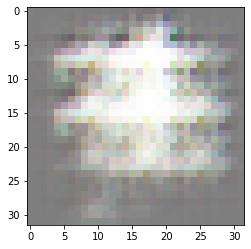

In [44]:
from tensorflow.keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
model = load_model('generator_model_200.h5')
# all 0s
vector = asarray([[0.8 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()

## Conclusion Part 2:
 Finally a nearly shapes are generated by Generator with an accuracy of 97% for fake generated images. The process is enhanced by using the more accurate activation function and bias variable.

## Author
    Bhagyashri Rangnath Gundal (NUID: 001081806)
    Master of Science in Information Systems
    Northeastern University, Boston, MA

## Citation
**References:**<br>
1. ADL (3 September 2018), "*An introduction to Q-Learning: reinforcement learning*" retrieved from https://www.freecodecamp.org/news/an-introduction-to-q-learning-reinforcement-learning-14ac0b4493cc/
2. Adesh Gautam (9 July 2018),"*Introduction to Reinforcement Learning (Coding Q-Learning) — Part 3*" retrieved from https://medium.com/swlh/introduction-to-reinforcement-learning-coding-q-learning-part-3-9778366a41c0
3. Richard S. Sutton and Andrew G. Barto (2018), "*Reinforcement Learning - An Introduction*".

## Licensing
Copyright 2020 Bhagyashri Rangnath Gundal

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.